In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

# Gaussian Mixture Models

In [5]:
methods = ['kmeans', 'gmm_full', 'gmm_tied', 'gmm_diag', 'gmm_spherical']
list_n_cluster = np.arange(2,6,1)
list_n_cluster

array([2, 3, 4, 5])

In [6]:
# Create Empty Dictionary
dict_results = {}
for method in methods:
  dict_temp = {}
  for n_cluster in list_n_cluster:
    dict_entry = {'silhouette_score': np.nan, 'ch_score': np.nan, 'model_specific_score': np.nan}
    dict_temp.update({n_cluster:dict_entry})
  dict_results.update({method: dict_temp})

In [7]:
# Experiments
cov_type='full'
for method in methods:
  method_name = method
  if method[:3]=='gmm':
    method_name = method.rsplit('_')[0]
    cov_type = method.rsplit('_')[1]
  for n_cluster in list_n_cluster:
    df, cluster_input_cols, answers_train, answers, labels, model_specific_score = get_cluster_data(n_cluster=n_cluster, method=method_name, cov_type=cov_type, cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
    dict_results[method][n_cluster]['silhouette_score'] = metrics.silhouette_score(answers, labels, metric='euclidean')
    dict_results[method][n_cluster]['ch_score'] = metrics.calinski_harabasz_score(answers, labels)
    dict_results[method][n_cluster]['model_specific_score'] = model_specific_score

In [8]:
# Transform Dictionary to DataFrame
df_results = pd.DataFrame(columns=['method', 'number_cluster', 'silhouette_score', 'ch_score', 'model_specific_score'])
for method in methods:
  df_temp = pd.DataFrame.from_dict(dict_results[method], orient='index')
  df_temp['number_cluster'] = df_temp.index
  df_temp['method'] = method
  df_results = df_results.append(df_temp)
df_results.reset_index(inplace=True, drop=True)
df_results

,method,number_cluster,silhouette_score,ch_score,model_specific_score
0,kmeans,2,0.186778,10527.624188,9059.162575
1,kmeans,3,0.154079,9622.823339,7948.818976
2,kmeans,4,0.158120,8109.291381,7356.845667
3,kmeans,5,0.143605,7360.072856,6871.020755
4,gmm_full,2,0.160660,6216.001451,-124545.218055
5,gmm_full,3,0.023151,4081.257193,-132901.624673
6,gmm_full,4,0.036389,3876.857273,-137174.026087
7,gmm_full,5,0.019658,3436.211298,-172582.693035
8,gmm_tied,2,0.241304,3581.647359,-103728.306894
9,gmm_tied,3,0.141981,6036.290263,-104214.956975


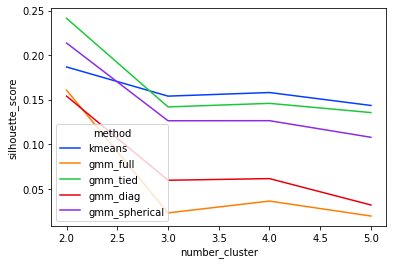

In [9]:
sns.lineplot(data=df_results, x='number_cluster', y='silhouette_score', hue='method', palette='bright')

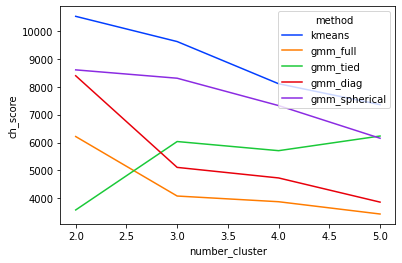

In [10]:
sns.lineplot(data=df_results, x='number_cluster', y='ch_score', hue='method', palette='bright')

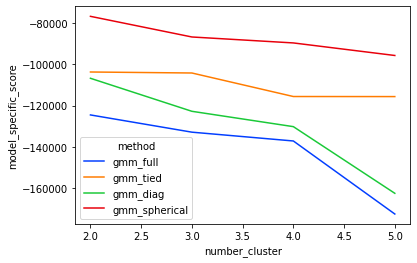

In [11]:
sns.lineplot(data=df_results[df_results['method']!='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright')

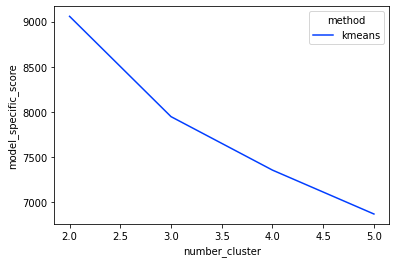

In [12]:
sns.lineplot(data=df_results[df_results['method']=='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright')

In [13]:
df_results.to_csv('results/clustering/results_clustering.csv', index=False)